In [1]:
################ select features using random forest and then apply lstm #################

In [2]:
# 1. Import libraries:
%matplotlib inline
import os
import quandl
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as spo
from scipy.stats import kurtosis, skew
import seaborn as sns
# from financial_data import *
import tensorflow as tf
mlp.style.use('seaborn')
quandl.save_key('HtwBLPt3k37yZHTvy15K')

/var/folders/dk/mxqr91nj7135zkb7ptp3mq5c0000gn/T/ipykernel_30939/4242266090.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mlp.style.use('seaborn')


In [3]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(sp_url, header=0)[0]
sp500.head()



,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
# Correct invalid dates:
sp500.loc[sp500[sp500['Date added']=='1983-11-30 (1957-03-04)'].index,'Date added'] = '1983-11-30'
sp500.loc[sp500[sp500['Date added']=='2001?'].index,'Date added'] = '2001-01-01'
# Filter firms that entered the index after December 2015:
sp500['Date added'] = pd.to_datetime(sp500['Date added'],format='%Y-%m-%d')
sp500 = sp500[sp500['Date added']<'2007-01-01']
print("The number of stocks in the universe is:", sp500.shape[0])

The number of stocks in the universe is: 241


In [5]:
n_stocks = 5
np.random.seed(2)
universe_tickers = sp500['Symbol'].unique()
tickers = list(np.random.choice(universe_tickers,replace=False,size=n_stocks))
print(tickers)


['BK', 'CTAS', 'T', 'CSCO', 'MRK']


In [6]:
# # 'data' will be a Pandas DataFrame containing the historical data for the specified tickers
# print(data)


def download_data(tickers, start_date, end_date, columns):
    data = yf.download(tickers, start=start_date, end=end_date)
    data=data[columns]
    return data

# Define the tickers, start date, end date, and columns you want to download
start_date = '2007-01-01'
end_date = '2022-12-31'
columns = [ 'Adj Close']

# Download the data
data = download_data(tickers, start_date, end_date, columns)
# print(data)


def one_lvl_colnames(df,cols,tickers):
    """This function changes a multi-level column indexation into a one level
    column indexation

    Inputs:
    -------
    df (pandas Dataframe): dataframe with the columns whose indexation will be 
        flattened.
    tickers (list|string): list/string with the tickers (s) in the data frame df.
    cols (list|string): list/string with the name of the columns (e.g. 'Adj Close',
        'High', 'Close', etc.) that are in the dataframe df.
    
    Ouputs:
    -------
    df (pandas Dataframe): dataframe with the same information as df, but 
        with one level of indexation.
    """
    df_not_renamed=df.copy()
    # Define important variables:
    if isinstance(tickers, str):
        tickers = [tickers]
    if isinstance(cols, str):
        
        cols = [cols]
    # For multi-level column indexing:
    if isinstance(df.columns.values[0], tuple):

        # Define important varibles
        columns = df.columns.values
        new_cols = []

        # Itarate through the multi-level column names and flatten them:
        for col in columns:
            temp = []
            for name in col:
                if name != '':
                    temp.append(name)
            new_temp = '_'.join(temp)
            new_cols.append(new_temp)
        
        # Change the column names:
        df.columns = new_cols
    
    # For uni-level colum indexing:
    elif isinstance(df.columns.values[0], str):
        
        # Define new names:
        col_names = [column+'_'+ticker for column in cols\
                     for ticker in tickers]
        df.columns = col_names
    

    return df

df2=pd.DataFrame(one_lvl_colnames(data,cols=columns,tickers=tickers))
df2_columns=list(df2.columns)
df2.columns = [col.replace('Adj Close', 'Close') for col in df2_columns]
df2.reset_index(inplace=True)
print(df2)
df2['weekday'] = df2['Date'].dt.dayofweek
df2=df2[df2['weekday']==0].reset_index(drop=True)
df2.drop(columns=['weekday'],inplace=True)
df2=df2.set_index('Date')
df2.tail()


[*********************100%%**********************]  5 of 5 completed
           Date   Close_BK  Close_CSCO  Close_CTAS   Close_MRK    Close_T
0    2007-01-03  28.612909   19.106241   31.573702   23.187101   7.615338
1    2007-01-04  28.555231   19.609217   31.604942   23.761240   7.517290
2    2007-01-05  28.418261   19.616106   31.464367   23.334578   7.399629
3    2007-01-08  28.533604   19.726345   31.495615   23.329317   7.470337
4    2007-01-09  28.411057   19.616106   31.440945   23.113354   7.499059
...         ...        ...         ...         ...         ...        ...
4023 2022-12-23  43.078899   46.067886  453.706848  109.603195  17.157436
4024 2022-12-27  43.242920   46.116402  455.483063  109.857956  17.297995
4025 2022-12-28  43.059605   45.670086  447.554810  108.838928  17.073101
4026 2022-12-29  44.053360   46.087299  453.419128  108.584167  17.288624
4027 2022-12-30  43.918289   46.223125  448.130310  108.711555  17.251141

[4028 rows x 6 columns]


,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T
Date,,,,,
2022-11-21,43.078899,46.203724,446.185455,102.798195,17.654074
2022-11-28,43.223621,46.650043,450.829315,105.562576,17.635334
2022-12-05,42.490364,47.862869,455.860107,107.081055,17.569738
2022-12-12,43.271858,47.833759,453.885498,106.068741,18.085119
2022-12-19,42.615788,45.990269,440.083008,107.232018,16.735764


In [7]:
df2.head()

,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T
Date,,,,,
2007-01-08,28.533604,19.726345,31.495615,23.329317,7.470337
2007-01-22,29.557226,18.279432,31.901705,23.861320,7.792923
2007-01-29,28.933905,18.058943,32.331226,23.971951,8.066903
2007-02-05,29.926867,18.954659,32.725349,23.482077,8.349717
2007-02-12,30.506702,18.975327,33.040676,23.097557,8.166327


In [8]:
pd.set_option('display.max_rows', 100)

In [9]:

pd.DataFrame(np.isinf(df2).sum()).sort_values(by=0,ascending=False).head(50)

,0
Close_BK,0
Close_CSCO,0
Close_CTAS,0
Close_MRK,0
Close_T,0


In [10]:
df2

,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T
Date,,,,,
2007-01-08,28.533604,19.726345,31.495615,23.329317,7.470337
2007-01-22,29.557226,18.279432,31.901705,23.861320,7.792923
2007-01-29,28.933905,18.058943,32.331226,23.971951,8.066903
2007-02-05,29.926867,18.954659,32.725349,23.482077,8.349717
2007-02-12,30.506702,18.975327,33.040676,23.097557,8.166327
...,...,...,...,...,...
2022-11-21,43.078899,46.203724,446.185455,102.798195,17.654074
2022-11-28,43.223621,46.650043,450.829315,105.562576,17.635334
2022-12-05,42.490364,47.862869,455.860107,107.081055,17.569738


In [11]:

model_data=df2.copy().reset_index()

model_data.fillna(method='ffill',inplace=True)
model_data.fillna(method='bfill',inplace=True)
for ticker in tickers:
    print(ticker)
    model_data["Close_"+ticker] = model_data["Close_"+ticker].pct_change()
#     print(model_data)

model_data=model_data.set_index('Date')
model_data=model_data[14:-21]


BK
CTAS
T
CSCO
MRK


In [12]:
pd.DataFrame(np.isinf(model_data).sum()).sort_values(by=0,ascending=False).head(50)

,0
Close_BK,0
Close_CSCO,0
Close_CTAS,0
Close_MRK,0
Close_T,0


In [13]:
np.isinf(model_data).sum().sum()

0

In [14]:
model_data

,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T
Date,,,,,
2007-04-30,-0.012683,0.006020,-0.006364,-0.004451,-0.026402
2007-05-07,0.022727,0.040015,0.030958,0.011470,0.022728
2007-05-14,-0.016184,-0.054657,-0.019674,0.000961,0.010858
2007-05-21,-0.015222,0.004184,-0.011090,0.032834,0.012990
2007-06-04,0.004487,0.023106,0.068358,-0.037925,0.008632
...,...,...,...,...,...
2022-06-06,0.028425,0.045675,0.073296,-0.042524,0.009643
2022-06-13,-0.097497,-0.046106,-0.099567,-0.053874,-0.056351
2022-06-27,0.038341,0.012257,0.061646,0.119796,0.051619


In [15]:
class WindowGenerator():
    """This class takes time series data that is in a sequential format, transforming
    it into pairs of inputs and labels, so that the inputs are windows of consecutive
    samples from the data.
    """
    def __init__(self,input_width=5,label_width=1,shift=1, train_df=None, val_df=None,
                 test_df=None, label_columns=None,batch_size=None,shuffle=False):
        """This method initiates the WindowGenerator class.

        Inputs:
        -------
        input_width (int, default=5): the width of the window, which represents the 
            amount of time steps from the earliest input observation to the last.
        label_width (int, default=1): the width of the label. This determines the amount
             of time steps that will be predicted.
        shift (int, default=1): jump between the last input in the window and the first 
            label.
        train_df (pandas Dataframe, default=None): array-like object containing the train 
            data which comes in a time series format.
        val_df (pandas Dataframe, default=None): array-like object containing the 
            validation data.
        test_df (pandas Dataframe, default=None): array-like object containing the test 
            data.
        label_columns (list|string, default=None): name of the column(s) that are used 
            as labels.
        batch_size (int, deafault=None): the size of the batches of the tf.data.Dataset
            object (whose dimensions are (batch,input_width,features) for the input and
            (batch,label_width,label_columns) for the labels).
        shuffle (boolean, default=False): determines if the data inside the tf.data.Dataset
            is shuffled.
        
        Outputs:
        --------
        None
        """
        # Define attributes of the class:
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Define information about columns:
        if isinstance(label_columns,type(None)):
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}

        # Define window information:
        self.total_window_size = input_width+shift
        self.input_slice = slice(0,input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size-self.label_width
        self.labels_slice = slice(self.label_start,None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        """This method determines what is returned when an instance of the object
        is called
        """
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        """This method converts a list of consecutive inputs to a window of
        inputs and a window of labels.

        Inputs:
        -------
        features (pandas Dataset): features in the dataframe

        Outputs:
        --------
        inputs ()
        """
        inputs = features[:, self.input_slice,:]
        labels = features[:,self.labels_slice,:]
        if not isinstance(self.label_columns,type(None)):
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis = -1
            )
        
        # Set the shapes of the informaiton:
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])

        return inputs,labels
    
    def make_dataset(self,data):
        """This method takes a time series DataFrame and convert it to a 
        tf.data.Dataset of (input_window,label_window) pairs, using the
        tf.keras.preprocessing.timeseries_dataset_from_array function.

        Input:
        ------
        data (pandas DataFrame): dataframe containing the time series information
            of the inputs and labels, which will transformed into windows and then 
            a tf.Dataset object.
        
        Outputs:
        --------

        """
        data = np.array(data,dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data = data,
            targets = None,
            sequence_length = self.total_window_size,
            sequence_stride = 1,
            shuffle = self.shuffle,
            batch_size = self.batch_size
        )
        ds = ds.map(self.split_window)
        print("************************************************")
        print(ds)

        return ds

    # Adding properties for accessing the train, val and test as tf.data.Dataset objects
    @property
    def train(self):
        if isinstance(self.train_df,type(None)):
            return None
        else:
            return self.make_dataset(self.train_df)
        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")    
        print(self.train_df)

    @property
    def val(self):
        if isinstance(self.val_df,type(None)):
            return None
        else:
            return self.make_dataset(self.val_df)

    @property
    def test(self):
        if isinstance(self.test_df,type(None)):
            return None
        else:
            return self.make_dataset(self.test_df)
    

In [16]:
label_cols=[col for col in model_data.columns if "Close" in col ]
label_cols

['Close_BK', 'Close_CSCO', 'Close_CTAS', 'Close_MRK', 'Close_T']

In [17]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
model_data [model_data.columns] = sc.fit_transform(model_data )




In [18]:
model_data.columns

Index(['Close_BK', 'Close_CSCO', 'Close_CTAS', 'Close_MRK', 'Close_T'], dtype='object')

In [19]:
model_data.replace([np.inf, -np.inf], 0, inplace=True)
model_data.ffill(inplace=True)
model_data.bfill(inplace=True)
# model_data=model_data[1:]
model_data

,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T
Date,,,,,
2007-04-30,0.448994,0.541402,0.491655,0.404143,0.442101
2007-05-07,0.521211,0.639271,0.575802,0.441619,0.606599
2007-05-14,0.441854,0.366723,0.461648,0.416884,0.566858
2007-05-21,0.443816,0.536119,0.481000,0.491908,0.573996
2007-06-04,0.484011,0.590592,0.660123,0.325351,0.559403
...,...,...,...,...,...
2022-06-06,0.532830,0.655564,0.671257,0.314526,0.562790
2022-06-13,0.276020,0.391340,0.281521,0.287811,0.341822
2022-06-27,0.553054,0.559359,0.644991,0.696603,0.703337


In [20]:


# Define train (70%), val (20%) and test (10%) dataframes: 
train_p, val_p, test_p = 0.7,0.2,0.1
window_size = 5
num_features = model_data.shape[1]
total_size = len(model_data)
train_size = int(total_size*train_p)
val_size = int(total_size*val_p)
test_size = int(total_size*test_p)


train_df = model_data.iloc[:train_size,:]
val_df = model_data.iloc[train_size-window_size:train_size+val_size,:]
test_df = model_data.iloc[train_size+val_size-window_size:,:]

In [21]:
# Define the batch size:
batch_size = 100

# Create an instance of the WindowGenerator object:
my_window = WindowGenerator(input_width=window_size,label_width=1,shift=1,train_df=train_df,val_df=val_df,
                            test_df=test_df,label_columns=label_cols,
                            batch_size=batch_size,shuffle=True)
print(my_window)

# Print the shapes for one batch of each sub dataset:
for example_inputs, example_labels in my_window.train.take(1):
    print("Train input shape:",example_inputs.shape)
    print("Train target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.val.take(1):
    print("Validation input shape:",example_inputs.shape)
    print("Validation target shape:",example_labels.shape)
for example_inputs, example_labels in my_window.test.take(1):
    print("Test input shape:",example_inputs.shape)
    print("Test target shape:",example_labels.shape)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['Close_BK', 'Close_CSCO', 'Close_CTAS', 'Close_MRK', 'Close_T']
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
Train input shape: (100, 5, 5)
Train target shape: (100, 1, 5)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
Validation input shape: (100, 5, 5)
Validation target shape: (100, 1, 5)
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
Test input shape: (73, 5, 5)
Test target shape: (73, 1, 5)


In [22]:
num_features

5

In [23]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [24]:
my_window.train

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>


<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>

In [25]:
model_data.describe()

,Close_BK,Close_CSCO,Close_CTAS,Close_MRK,Close_T
count,721.000000,721.000000,721.000000,721.000000,721.000000
mean,0.478219,0.529640,0.515725,0.419995,0.535522
std,0.101061,0.116119,0.090108,0.084765,0.100795
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.432236,0.473925,0.474477,0.378408,0.484231
50%,0.480230,0.532813,0.513138,0.418094,0.536776
75%,0.525731,0.588036,0.554646,0.465811,0.587292
max,1.000000,1.000000,1.000000,1.000000,1.000000



Training with initial learning rate: 0.001


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 5, 128)            68608     
                                                                 
 LSTM_2 (LSTM)               (None, 64)                49408     
                                                                 
 Dense_1 (Dense)             (None, 50)                3250      
                                                                 
 Returns (Dense)             (None, 5)                 255       
                                                                 
Total params: 121521 (474.69 KB)
Trainable params: 121521 (474.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), Tensor

INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 3s 465ms/step - loss: 0.1208 - root_mean_squared_error: 0.4915 - mae: 0.4767 - val_loss: 0.1006 - val_root_mean_squared_error: 0.4462 - val_mae: 0.4267 - lr: 0.0010
Epoch 2/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0969 - root_mean_squared_error: 0.4402 - mae: 0.4245
Epoch 2: Learning Rate = 0.0010000000474974513, Loss = 0.08018362522125244

Epoch 2: val_loss improved from 0.10064 to 0.05165, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 378ms/step - loss: 0.0802 - root_mean_squared_error: 0.4006 - mae: 0.3772 - val_loss: 0.0517 - val_root_mean_squared_error: 0.3235 - val_mae: 0.2851 - lr: 0.0010
Epoch 3/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.3117 - mae: 0.2763
Epoch 3: Learning Rate = 0.0010000000474974513, Loss = 0.03298820182681084

Epoch 3: val_loss improved from 0.05165 to 0.01951, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 419ms/step - loss: 0.0330 - root_mean_squared_error: 0.2570 - mae: 0.2120 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1978 - val_mae: 0.1652 - lr: 0.0010
Epoch 4/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.1878 - mae: 0.1598
Epoch 4: Learning Rate = 0.0010000000474974513, Loss = 0.016131006181240082

Epoch 4: val_loss improved from 0.01951 to 0.01063, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 399ms/step - loss: 0.0161 - root_mean_squared_error: 0.1797 - mae: 0.1444 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1480 - val_mae: 0.1181 - lr: 0.0010
Epoch 5/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0088 - root_mean_squared_error: 0.1324 - mae: 0.1058
Epoch 5: Learning Rate = 0.0010000000474974513, Loss = 0.007619773503392935

Epoch 5: val_loss improved from 0.01063 to 0.00856, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 370ms/step - loss: 0.0076 - root_mean_squared_error: 0.1234 - mae: 0.0943 - val_loss: 0.0086 - val_root_mean_squared_error: 0.1293 - val_mae: 0.0991 - lr: 0.0010
Epoch 6/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.1216 - mae: 0.0913
Epoch 6: Learning Rate = 0.0010000000474974513, Loss = 0.007936096750199795

Epoch 6: val_loss improved from 0.00856 to 0.00787, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 421ms/step - loss: 0.0079 - root_mean_squared_error: 0.1260 - mae: 0.0957 - val_loss: 0.0079 - val_root_mean_squared_error: 0.1239 - val_mae: 0.0936 - lr: 0.0010
Epoch 7/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.1154 - mae: 0.0873
Epoch 7: Learning Rate = 0.0010000000474974513, Loss = 0.0066759404726326466

Epoch 7: val_loss did not improve from 0.00787
5/5 [==============================] - 0s 16ms/step - loss: 0.0067 - root_mean_squared_error: 0.1156 - mae: 0.0852 - val_loss: 0.0079 - val_root_mean_squared_error: 0.1254 - val_mae: 0.0912 - lr: 0.0010
Epoch 8/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0077 - root_mean_squared_error: 0.1242 - mae: 0.0887
Epoch 8: Learning Rate = 0.0010000000474974513, Loss = 0.006133570801466703

Epoch 8: val_loss improved from 0.00787 to 0.00638, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_mode

INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 415ms/step - loss: 0.0061 - root_mean_squared_error: 0.1108 - mae: 0.0793 - val_loss: 0.0064 - val_root_mean_squared_error: 0.1143 - val_mae: 0.0811 - lr: 0.0010
Epoch 9/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.1163 - mae: 0.0792
Epoch 9: Learning Rate = 0.0010000000474974513, Loss = 0.0052111526019871235

Epoch 9: val_loss did not improve from 0.00638
5/5 [==============================] - 0s 16ms/step - loss: 0.0052 - root_mean_squared_error: 0.1021 - mae: 0.0714 - val_loss: 0.0064 - val_root_mean_squared_error: 0.1146 - val_mae: 0.0822 - lr: 0.0010
Epoch 10/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.1054 - mae: 0.0741
Epoch 10: Learning Rate = 0.0010000000474974513, Loss = 0.0054559726268053055

Epoch 10: val_loss improved from 0.00638 to 0.00636, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_

INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 406ms/step - loss: 0.0055 - root_mean_squared_error: 0.1045 - mae: 0.0739 - val_loss: 0.0064 - val_root_mean_squared_error: 0.1115 - val_mae: 0.0803 - lr: 0.0010
Epoch 11/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.1146 - mae: 0.0797
Epoch 11: Learning Rate = 0.0009000000427477062, Loss = 0.005326585378497839

Epoch 11: val_loss improved from 0.00636 to 0.00626, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 374ms/step - loss: 0.0053 - root_mean_squared_error: 0.1032 - mae: 0.0731 - val_loss: 0.0063 - val_root_mean_squared_error: 0.1074 - val_mae: 0.0777 - lr: 9.0000e-04
Epoch 12/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.1150 - mae: 0.0790
Epoch 12: Learning Rate = 0.0009000000427477062, Loss = 0.0051420871168375015

Epoch 12: val_loss improved from 0.00626 to 0.00619, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 411ms/step - loss: 0.0051 - root_mean_squared_error: 0.1014 - mae: 0.0708 - val_loss: 0.0062 - val_root_mean_squared_error: 0.1121 - val_mae: 0.0789 - lr: 9.0000e-04
Epoch 13/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0970 - mae: 0.0670
Epoch 13: Learning Rate = 0.0009000000427477062, Loss = 0.005118010099977255

Epoch 13: val_loss improved from 0.00619 to 0.00618, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 397ms/step - loss: 0.0051 - root_mean_squared_error: 0.1012 - mae: 0.0701 - val_loss: 0.0062 - val_root_mean_squared_error: 0.1104 - val_mae: 0.0783 - lr: 9.0000e-04
Epoch 14/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0946 - mae: 0.0663
Epoch 14: Learning Rate = 0.0009000000427477062, Loss = 0.0051238806918263435

Epoch 14: val_loss improved from 0.00618 to 0.00613, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 398ms/step - loss: 0.0051 - root_mean_squared_error: 0.1012 - mae: 0.0702 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1077 - val_mae: 0.0765 - lr: 9.0000e-04
Epoch 15/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0047 - root_mean_squared_error: 0.0971 - mae: 0.0708
Epoch 15: Learning Rate = 0.0009000000427477062, Loss = 0.005091425031423569

Epoch 15: val_loss improved from 0.00613 to 0.00612, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 372ms/step - loss: 0.0051 - root_mean_squared_error: 0.1009 - mae: 0.0701 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1077 - val_mae: 0.0765 - lr: 9.0000e-04
Epoch 16/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0050 - root_mean_squared_error: 0.0995 - mae: 0.0702
Epoch 16: Learning Rate = 0.0009000000427477062, Loss = 0.005067210644483566

Epoch 16: val_loss improved from 0.00612 to 0.00611, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 411ms/step - loss: 0.0051 - root_mean_squared_error: 0.1007 - mae: 0.0698 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1129 - val_mae: 0.0791 - lr: 9.0000e-04
Epoch 17/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0907 - mae: 0.0630
Epoch 17: Learning Rate = 0.0009000000427477062, Loss = 0.005069774575531483

Epoch 17: val_loss did not improve from 0.00611
5/5 [==============================] - 0s 16ms/step - loss: 0.0051 - root_mean_squared_error: 0.1007 - mae: 0.0697 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1137 - val_mae: 0.0799 - lr: 9.0000e-04
Epoch 18/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0991 - mae: 0.0724
Epoch 18: Learning Rate = 0.0009000000427477062, Loss = 0.005067533813416958

Epoch 18: val_loss improved from 0.00611 to 0.00610, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written 

INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 400ms/step - loss: 0.0051 - root_mean_squared_error: 0.1007 - mae: 0.0697 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1131 - val_mae: 0.0790 - lr: 9.0000e-04
Epoch 19/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.1041 - mae: 0.0751
Epoch 19: Learning Rate = 0.0009000000427477062, Loss = 0.005084695294499397

Epoch 19: val_loss improved from 0.00610 to 0.00608, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 405ms/step - loss: 0.0051 - root_mean_squared_error: 0.1009 - mae: 0.0697 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1132 - val_mae: 0.0795 - lr: 9.0000e-04
Epoch 20/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.1063 - mae: 0.0714
Epoch 20: Learning Rate = 0.0009000000427477062, Loss = 0.005072422791272402

Epoch 20: val_loss improved from 0.00608 to 0.00608, saving model to best_model_weekly_close_price_only
INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 386ms/step - loss: 0.0051 - root_mean_squared_error: 0.1007 - mae: 0.0697 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1083 - val_mae: 0.0766 - lr: 9.0000e-04
Epoch 21/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0043 - root_mean_squared_error: 0.0932 - mae: 0.0643
Epoch 21: Learning Rate = 0.00072900002123788, Loss = 0.005077255889773369

Epoch 21: val_loss did not improve from 0.00608
5/5 [==============================] - 0s 16ms/step - loss: 0.0051 - root_mean_squared_error: 0.1008 - mae: 0.0698 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1088 - val_mae: 0.0769 - lr: 7.2900e-04
Epoch 22/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.1139 - mae: 0.0780
Epoch 22: Learning Rate = 0.00072900002123788, Loss = 0.005061604082584381

Epoch 22: val_loss did not improve from 0.00608
5/5 [==============================] - 0s 16ms/step - loss: 0.0051 - root_mean_squared_erro

INFO:tensorflow:Assets written to: best_model_weekly_close_price_only/assets


5/5 [==============================] - 2s 415ms/step - loss: 0.0051 - root_mean_squared_error: 0.1006 - mae: 0.0696 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1036 - val_mae: 0.0742 - lr: 7.2900e-04
Epoch 24/100
1/5 [=====>........................] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0867 - mae: 0.0635
Epoch 24: Learning Rate = 0.00072900002123788, Loss = 0.005059989634901285

Epoch 24: val_loss did not improve from 0.00607
5/5 [==============================] - 0s 16ms/step - loss: 0.0051 - root_mean_squared_error: 0.1006 - mae: 0.0695 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1082 - val_mae: 0.0764 - lr: 7.2900e-04


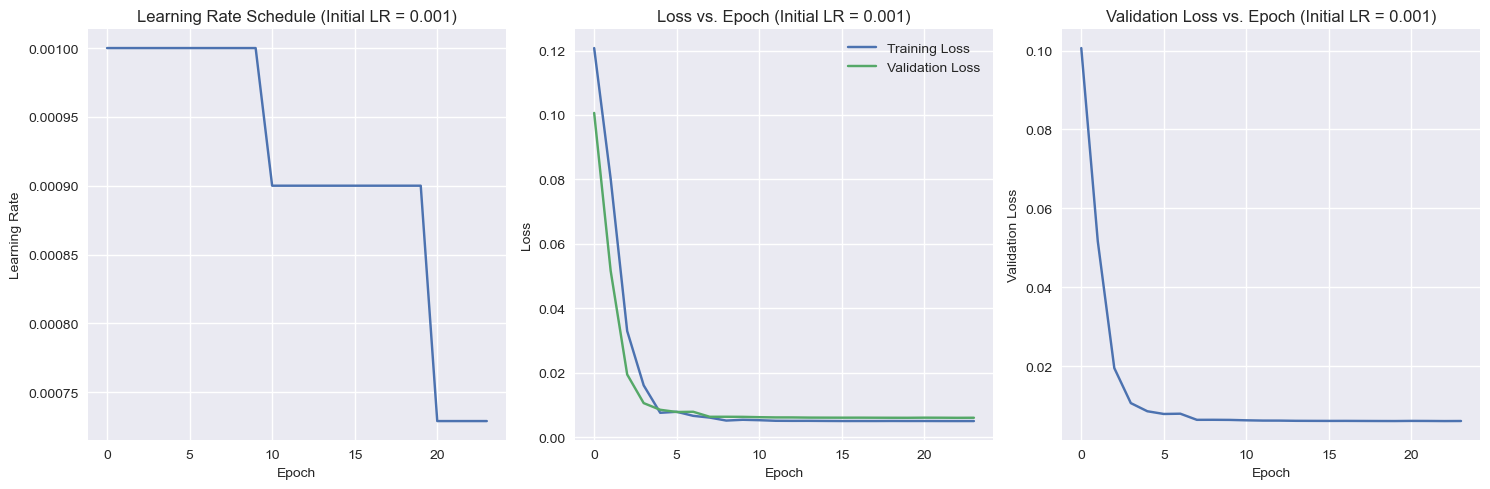

/Users/inderkaur/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training after no improvement for 10 epochs
restore_best_weights=False,  # Restore the best weights when stopping
min_delta=0.0001)

checkpont_rnn = ModelCheckpoint(
    filepath='best_model_weekly_close_price_only',
    save_weights_only=False,
    save_freq = 'epoch',
    monitor = 'val_loss',
    mode='min',
    save_best_only = True,
    verbose = 1)

# Initialize lists to store loss and learning rates
losses = []
learning_rates = []

# Custom callback to log loss and learning rate
class LossLearningRateCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        loss = logs['loss']
        learning_rates.append(lr)
#         print(learning_rates)
        losses.append(loss)
        print()
#         print(f"Learning Rate = {lr.numpy()}")
        print(f"Epoch {epoch+1}: Learning Rate = {lr.numpy()}, Loss = {loss}")
# 

# Create an instance of the custom callback
loss_lr_callback = LossLearningRateCallback()

def build_model(initial_lr=0.001):
    model_1 = Sequential([
#     BatchNormalization(
#         input_shape = (window_size,num_features),
#         name = 'Batch_Norm_1'),
    LSTM(128,return_sequences=True,name='LSTM_1',input_shape = (window_size,num_features)),
    
    LSTM(64,name='LSTM_2'),
    Dense(50,activation='relu',name='Dense_1'),
    Dense(len(tickers),name='Returns')
])
    

    optimizer = Adam(learning_rate=initial_lr)
    
    model_1.compile(
    loss=tf.keras.losses.Huber(),
    metrics=[tf.metrics.RootMeanSquaredError(),'mae'],
    optimizer=optimizer)
    
    return model_1


def lr_schedule(epoch, initial_lr=0.01, decay_factor=0.9, decay_epochs=10):
    if epoch<decay_epochs:
        return initial_lr
    elif epoch%decay_epochs!=0:
        return initial_lr
    else:
        return initial_lr * (decay_factor ** (epoch // decay_epochs))

# learning schedule callback
lr_rate = LearningRateScheduler(lr_schedule)
# print(lr_rate.numpy())
callbacks_list = [lr_rate,loss_lr_callback, early_stopping, checkpont_rnn]
callbacks_list



# Define a list to store validation losses for each learning rate


# List of initial learning rates to try
initial_learning_rates = [0.001]
# 0.001,0.01,0.1

best_model = None
best_val_loss = float('inf')
validation_losses = []
num_epochs=100
for lr in initial_learning_rates:
    
    print(f"\nTraining with initial learning rate: {lr}")
    model_1 = build_model(initial_lr=lr)
    print(model_1.summary())

    history = model_1.fit(my_window.train,
                          epochs=num_epochs,
                          callbacks=callbacks_list,
                          verbose=1,
                          validation_data=my_window.val)
    
    # Get the final validation loss for this learning rate
    final_val_loss = history.history['val_loss'][-1]
    validation_losses.append(final_val_loss)

    last_epoch = len(history.history['loss'])

    # Plot learning rate vs. epoch
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(len(history.history['loss'])), history.history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'Learning Rate Schedule (Initial LR = {lr})')

    # Plot epoch vs. loss
    plt.subplot(1, 3, 2)
    plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss vs. Epoch (Initial LR = {lr})')

    # Plot epoch vs. validation loss
    plt.subplot(1, 3, 3)
    plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title(f'Validation Loss vs. Epoch (Initial LR = {lr})')

    plt.tight_layout()
    plt.show()
    
    # Check if this model has the best validation loss
    if final_val_loss < best_val_loss:
        best_lr = lr
        best_val_loss = final_val_loss
        best_model = model_1

# Save the best model
if best_model is not None:
    best_model.save('best_model_weekly_close_price_only.h5')


In [27]:
print(f'\nBest Learning Rate: {best_lr}, Best Validation Loss: {best_val_loss}')



Best Learning Rate: 0.001, Best Validation Loss: 0.006085635162889957


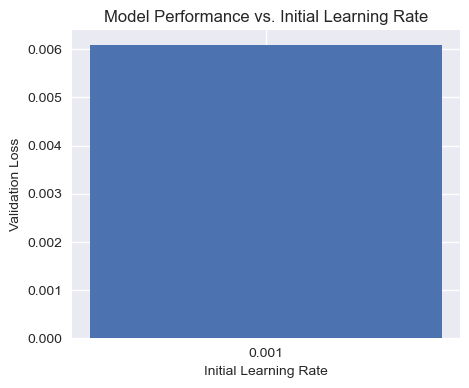

In [28]:
plt.figure(figsize=(5, 4))
# Plot the performance of each initial learning rate
plt.bar([str(lr) for lr in initial_learning_rates], validation_losses)
plt.xlabel('Initial Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Model Performance vs. Initial Learning Rate')
plt.show()

In [29]:
[str(lr) for lr in initial_learning_rates], validation_losses

(['0.001'], [0.006085635162889957])

In [30]:
from tensorflow.keras.models import load_model

final_model = load_model('best_model_weekly_close_price_only.h5')

In [31]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 5, 128)            68608     
                                                                 
 LSTM_2 (LSTM)               (None, 64)                49408     
                                                                 
 Dense_1 (Dense)             (None, 50)                3250      
                                                                 
 Returns (Dense)             (None, 5)                 255       
                                                                 
Total params: 121521 (474.69 KB)
Trainable params: 121521 (474.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
final_model.evaluate(my_window.test)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 242ms/step - loss: 0.0039 - root_mean_squared_error: 0.0882 - mae: 0.0664


[0.0038918759673833847, 0.08822557330131531, 0.06644213199615479]

In [33]:
# [0.000979768461547792, 0.044266656041145325, 0.034382160753011703]


In [34]:
def plot_window(tickers,window_dataset,pandas_dataset,window_size,model,
                figsize=(10,7)):
    """This function plots the observed returns inside a tf.data.Dataset and
    compares them with the predicted returns of a model.

    Inputs:
    -------
    window_dataset (tensorflow.data.Dataset object): dataset with both inputs
        and target values.
    pandas_dataset (pandas DataFrame): dataframe that was used to create the
        window_dataset.
    window_size (int): window size used in the transformation from sequential 
        time series into window time series.
    model (model object): trained model with the capability to predict in a
        similar manner than tensorflow.keras.Model object.
    figsize (tuple, default=(12,100)): tuple with the dimensions of the figure
        where the data will be plotted.
    
    Ouputs:
    -------
    None
    """
    # Determine the X-axis of the plot:
    plot_index = pandas_dataset.iloc[window_size:,:].index

    # Assign in the addecuate format the values of the observed taget variable(s):
    y = np.concatenate([targets for inputs,targets in window_dataset],axis=0)
#     print(y)
    
    # Use the model to predict the target variable(s):
    
    y_hat = model.predict(window_dataset)
    print("printing y hat of plot_window function")
    print(y_hat)
    # Adjust the shapes:
    y = y.reshape(y_hat.shape)
    print("printing y of plot_window function")
    print(y)

    # Plot the data:
    for n in range(y_hat.shape[1]):
        print(n)
        print(tickers[n])
        plt.figure(figsize=figsize)
        plt.subplot(y_hat.shape[1],1,n+1)
        plt.ylabel('Return')
        plt.plot(plot_index,y_hat[:,n],label='Predicted',color='maroon')
        plt.plot(plot_index,y[:,n],label='Observed',color='midnightblue',alpha=0.5)
        plt.title(tickers[n])
        plt.legend()

In [35]:
tickers

['BK', 'CTAS', 'T', 'CSCO', 'MRK']

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
5/5 [==============================] - 0s 3ms/step
printing y hat of plot_window function
[[0.48612663 0.538015   0.5200083  0.422616   0.53781235]
 [0.4896625  0.54281574 0.5248832  0.42573738 0.5426284 ]
 [0.47956702 0.5308321  0.5130656  0.41630304 0.5294785 ]
 ...
 [0.45746347 0.5060816  0.49119246 0.39611387 0.5040248 ]
 [0.4668447  0.5153472  0.49951878 0.4045701  0.51481456]
 [0.47206715 0.520089   0.5043246  0.40870005 0.5203716 ]]
printing y of plot_window function
[[0.4642308  0.45052904 0.4457091  0.40006208 0.46664694]
 [0.57408535 0.6214209  0.57664084 0.39525536 0.52132154]
 [0.39819196 0.50502825 0.447057   0.30815655 0.452674  ]
 ...
 [0.53482044 0.74030423 0.5197756  0.37190127 0.5765559 ]
 [0.46165678 0.5532559  0.50159395 0.4342004  0.5343674 ]
 [0.5839068  0.5904426  0.6

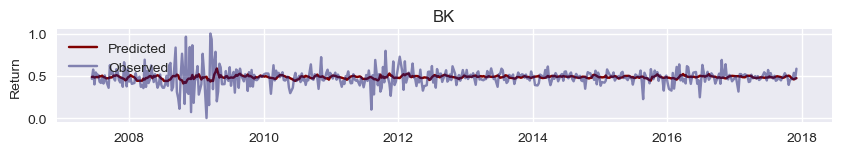

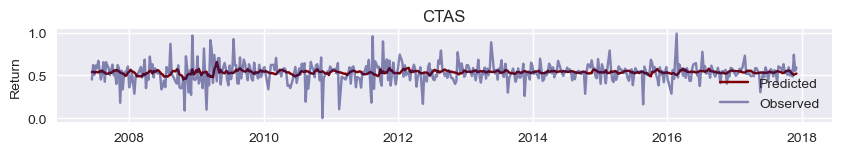

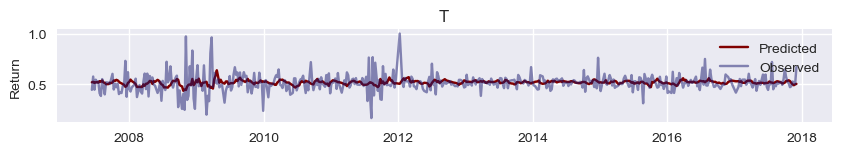

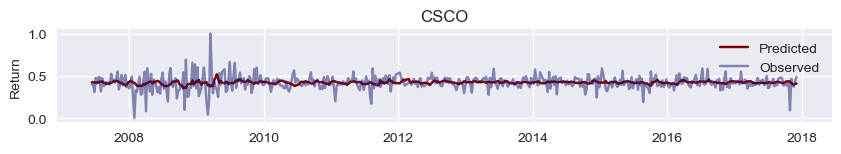

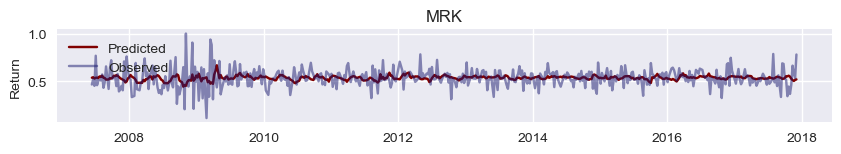

In [36]:
############# Training Results
# Create new WindowGenerator with the data not shuffled:
my_window_2 = WindowGenerator(
    input_width=window_size,
    label_width=1,
    shift=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    label_columns=label_cols,
    batch_size=batch_size,
    shuffle=False)

plot_window(tickers,my_window_2.train,train_df,window_size,final_model)

************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 21ms/step
printing y hat of plot_window function
[[0.50248146 0.555075   0.5371855  0.43576473 0.5587131 ]
 [0.48655587 0.53696066 0.5191798  0.42068377 0.5382102 ]
 [0.4950705  0.54776204 0.5302729  0.42881855 0.54980904]
 [0.49136302 0.54400444 0.52640265 0.42569098 0.54482573]
 [0.48492998 0.5358537  0.5182474  0.41948387 0.5358105 ]
 [0.48400265 0.5348154  0.5175653  0.41898248 0.5351004 ]
 [0.4854303  0.53706366 0.5191651  0.42044353 0.53740007]
 [0.48715922 0.5391285  0.52100235 0.42272183 0.5402619 ]
 [0.48653153 0.5384866  0.5217809  0.42181253 0.5395135 ]
 [0.47259736 0.52189183 0.506542   0.40900385 0.52169126]
 [0.48754513 0.5395709  0.523455   0.42316645 0.53991807]
 [0.49945784 0.5533839  0.5360114  0.4345814  0.55474514]
 [0.48994318 0

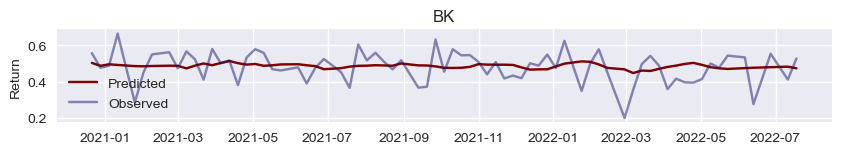

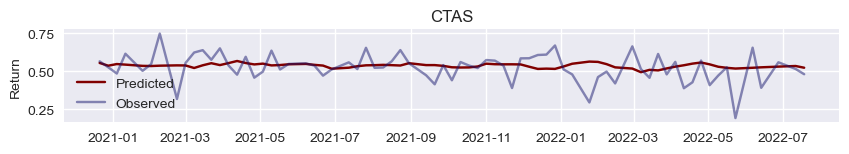

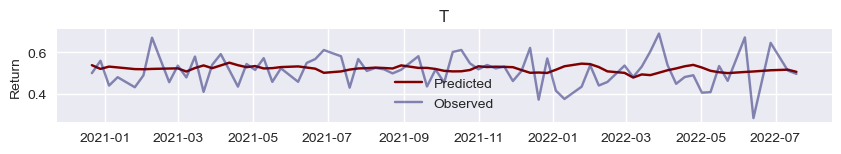

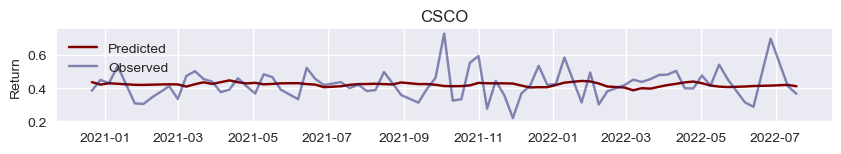

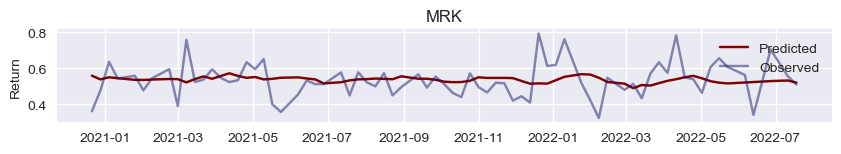

In [37]:
plot_window(tickers,my_window_2.test,test_df,window_size,final_model)

In [38]:
def optimize_portfolio(returns,guess_weights=None,rfr=0):
    """This function optimizes the weight allocation for the assets in a
    portfolio, represented by the returns.

    Inputs:
    -------
    returns (pandas DataFrame|Series): contains the returns information.
    guess_weights (list of numerical values, default=None): guess values for
        the weights of the different assets in the portfolio.
    short (boolena, default=True): define ifshort possitions are allowed or 
        not.
    rfr (numerical value, default=0): risk free rate, could be a series of
        the same length as returns.

    Outputs:
    --------
    opt_weights (array-like object): array with the optimal weights for the
        portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(guess_weights,type(None)):
        guess_weights = [1/num_assets for i in range(num_assets)]

    # Define bound if short possitions are allowed or not:
    
    bounds = [(0,1) for i in range(num_assets)]
    

    # Define constraints, if there can or not be leverage
    weights_sum_to_1 = {'type':'eq',
                        'fun':lambda weights: np.sum(np.absolute(weights))-1}
    # Minimize the function:
    opt_weights = spo.minimize(
        sharpe_ratio,
        guess_weights,
        args = (rfr, True, returns),
        method = 'SLSQP',
        options = {'disp':False},
        constraints = (weights_sum_to_1),
        bounds = bounds
    )

    return opt_weights 

In [39]:
def daily_rate(x, periods_year=252):
    """This function transforms a rate into a daily rate

    Inputs:
    -------
    x (numerical value): rate that you want to transform into a daily rate.
    periods_year (numerical value, default=252): amount of periods per year
        of the periodicity of rate x.
    
    Ouputs:
    -------
    df (numerical value): daily rate
    """
    dr = np.power(1+x,1/periods_year)-1
    return dr

In [40]:
def sharpe_ratio(weights=None, rfr=0, negative=False, returns=0):
    """Compute the Sharpe Ratio of a portfolio.

    Inputs:
    -------
    weights (list of numerical values, default=None): list with the weights
        of the assets in the portfolio.
    rfr (numerical value|array-like, default=0): risk-free rate.
    returns (pandas DataFrame|Series, default=0): returns of the assets in
        the portfolio.

    Outputs:
    --------
    sharpe_ratio (numerical value): Sharpe ratio of the portfolio.
    """
    # Define important variables:
    num_assets = returns.shape[1]
    if isinstance(weights,type(None)):
        weights = [1/num_assets for i in range(num_assets)]

    # Get portfolio returns:
    portfolio_returns = (returns*weights).sum(axis=1)
    portfolio_std = portfolio_returns.std()

    # Compute Sharpe Ratio formula:
    sharpe_ratio = (portfolio_returns-rfr).mean()/portfolio_std

    # If used in a minization process:
    if negative:
        sharpe_ratio *= -1

    return sharpe_ratio    

In [41]:
# Define the tickers
new_tickers = ['FRED/T10Y2Y','FRED/T10Y3M','FRED/DTB3','FRED/DLTIIT','FRED/TEDRATE']

# # Define the date range
names = ['10y2y_spread','10y3m_spread','3m_rate','ltiit','ted_spread']

# # Retrieve data
data_quandl = quandl.get(new_tickers, start_date=start_date, end_date=end_date)
data_quandl.columns = names

# # Print the data
print(data_quandl)

            10y2y_spread  10y3m_spread  3m_rate  ltiit  ted_spread
Date                                                              
2007-01-02         -0.12         -0.39     4.94   2.33        0.42
2007-01-03         -0.09         -0.38     4.92   2.32        0.44
2007-01-04         -0.09         -0.42     4.91   2.30        0.45
2007-01-05         -0.11         -0.40     4.92   2.33        0.44
2007-01-08         -0.12         -0.42     4.95   2.34        0.41
...                  ...           ...      ...    ...         ...
2022-07-12         -0.07          0.74     2.16   1.12         NaN
2022-07-13         -0.22          0.52     2.33   1.06         NaN
2022-07-14         -0.19          0.56     2.33   1.07         NaN
2022-07-15         -0.20          0.56     2.29   1.03         NaN
2022-07-18         -0.19          0.46      NaN    NaN         NaN

[3891 rows x 5 columns]


In [42]:
columns = ['FR_'+ticker for ticker in tickers]
y_train = final_model.predict(my_window_2.train)
y_val = final_model.predict(my_window_2.val)
y_test = final_model.predict(my_window_2.test)
y_hat_total = np.concatenate([y_train,y_val,y_test],axis=0)
ret_hat_df = pd.DataFrame(data=y_hat_total,index=model_data.index[5:],columns=columns)
rfr = data_quandl['3m_rate'].agg(daily_rate)
ret_hat_df = ret_hat_df.merge(rfr.rename('rfr'),left_index=True,right_index=True,
                             how='left')

opt_weights = np.array([optimize_portfolio(
    returns = window[ret_hat_df.columns[:-1]],
    rfr = window[ret_hat_df.columns[-1]]).x for window in ret_hat_df.rolling(40)])
opt_weights.shape


# Display the shape of opt_weights
print(f"Shape of optimized weights: {opt_weights.shape}")


************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
5/5 [==============================] - 0s 4ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
2/2 [==============================] - 0s 2ms/step
************************************************
<_MapDataset element_spec=(TensorSpec(shape=(None, 5, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 5), dtype=tf.float32, name=None))>
1/1 [==============================] - 0s 27ms/step
Shape of optimized weights: (716, 5)


In [43]:
model_data.shape

(721, 5)

In [44]:
opt_weights

array([[2.00000000e-01, 2.00000000e-01, 2.00000000e-01, 2.00000000e-01,
        2.00000000e-01],
       [1.00000000e+00, 2.29566366e-13, 3.50525164e-13, 0.00000000e+00,
        2.01255679e-13],
       [1.00000000e+00, 0.00000000e+00, 1.49880108e-15, 3.10862447e-15,
        0.00000000e+00],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 1.41227308e-13, 8.32355018e-14, 5.53966595e-14,
        1.46528623e-13]])